In [40]:
import pandas as pd
import numpy as np
import math
from collections import Counter, defaultdict
from itertools import combinations
import ast

import visualizations as viz

from nltk import FreqDist, bigrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

import plotly.express as px
import matplotlib.pyplot as plt

from wordcloud import WordCloud

# source work : https://github.com/nonlocal-lia/sentiment-analysis-project/blob/main/main_notebook.ipynb

# Variance-based importance measures for machine : https://hal.science/hal-03741384/document
# keyness index
# prendre en compte les produits qui n'ont pas de nutri-score

In [41]:
arcom_df = pd.read_csv('data/cross_arcom_off/arcom_data_with_nutriscore.csv')
arcom_df['clean_script'] = [ast.literal_eval(script) for script in arcom_df['clean_script']]

In [42]:
score_list = ['a', 'b', 'c', 'd', 'e']

In [43]:
def clean_themes(themes):
    if type(themes) == str:
        themes = themes.split(',')
        themes = [theme.strip() for theme in themes]
        themes = [theme.lower() for theme in themes]
        return themes
    return []

themes = arcom_df['Thème'].apply(clean_themes)
arcom_df['clean_theme'] = themes

In [44]:
arcom_df.columns

Index(['Unnamed: 0', 'N° Fiche', 'year', 'week', 'N° Version', 'Annonceur',
       'Marque', 'Produit', 'Date', 'Date VP', 'Média', 'Medium', 'Catégorie',
       'Support', 'Format', 'Secteur', 'Classe', 'Groupe', 'Variété',
       'N° Groupe/Variété', 'Signature', 'Script', 'Incrustation', 'Titre',
       'Libellé Version', 'Visuel', 'Mots Clés', 'Thème',
       'Musique / Auteur compositeur', 'Musique / Titre', 'Agence',
       'Réalisateur', 'Producteur', 'Récompense', 'Musique / Version',
       'Type de campagne', 'Musique / Interprète', 'Partenaires',
       'Titre émission', 'Hashtag', 'clean_script', 'mots_clefs_themes',
       'mots_clefs_themes_str', 'visuel_str', 'visuel_clean',
       'visuel_clean_bigram', 'clean_bigram_total', 'date_iso', 'month_nb',
       'Produit_cleaned', 'nutriscore_inferred', 'script_decoded',
       'date_formatted', '6_month_interval', 'clean_theme'],
      dtype='object')

In [45]:
arcom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5564 entries, 0 to 5563
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    5564 non-null   int64  
 1   N° Fiche                      5564 non-null   int64  
 2   year                          5564 non-null   int64  
 3   week                          5564 non-null   int64  
 4   N° Version                    5564 non-null   float64
 5   Annonceur                     5564 non-null   object 
 6   Marque                        5564 non-null   object 
 7   Produit                       5564 non-null   object 
 8   Date                          5564 non-null   object 
 9   Date VP                       5061 non-null   object 
 10  Média                         5564 non-null   object 
 11  Medium                        5564 non-null   object 
 12  Catégorie                     5564 non-null   object 
 13  Sup

# Value count per score

In [46]:
for score in ['a','b','c','d','e']:
    sub_score_df = arcom_df[arcom_df['nutriscore_inferred'] == score]
    fig = px.histogram(sub_score_df,
                x='Variété',
                marginal='rug', 
                color='Annonceur', title=f'Type of products graded {score.upper()}')
    fig.show()

In [47]:
nutriscore_order = ['a', 'b', 'c', 'd', 'e']

fig = px.histogram(arcom_df,
            x='nutriscore_inferred',
            color='Variété', 
            title=f'Count of ads per nutriscore',
            category_orders={'nutriscore_inferred': nutriscore_order})
fig.show()

In [48]:
category_counts = arcom_df['Variété'].value_counts()
sorted_categories = category_counts.index.tolist()

fig = px.histogram(arcom_df,
            x='Variété',
            color='nutriscore_inferred', 
            title=f'Count of nutriscore per category',
            color_discrete_sequence=px.colors.sequential.Jet,
            category_orders={'Variété': sorted_categories, 'nutriscore_inferred': nutriscore_order})
fig.show()

In [49]:
kw_list = ['CEREALES', 'DESSERTS FRAIS', 'YAOURTS', 'BISCUITS FOURRES-TARTINES', 'ALIMENTS DIETETIQUES']
for kw in kw_list:
    sub_score_df = arcom_df[arcom_df['Variété'] == kw]

    fig = px.histogram(sub_score_df,
                x='Produit',
                color='nutriscore_inferred', 
                title=f'Product for {kw}',
                color_discrete_sequence=px.colors.sequential.Jet,
                category_orders={'nutriscore_inferred': nutriscore_order})
    fig.show()

In [50]:
brands_counts = arcom_df['Annonceur'].value_counts()
sorted_brands = brands_counts.index.tolist()

fig = px.histogram(arcom_df,
            x='Annonceur',
            color='nutriscore_inferred', 
            title=f'Count of nutriscore per brand',
            color_discrete_sequence=px.colors.sequential.Jet,
            category_orders={'Annonceur': sorted_brands, 'nutriscore_inferred': nutriscore_order})
fig.show()

In [51]:
sorted_categories

['TABLETTES DE CHOCOLAT',
 'CEREALES',
 'BISCUITS FOURRES-TARTINES',
 'BISCUITS CHOCOLATES',
 'DESSERTS FRAIS',
 'VIENNOISERIES',
 'DOSETTES-CAPSULES A CAFE',
 'PAINS',
 'YAOURTS',
 'CONFISERIES DE CHOCOLAT',
 'BONBONS-SUCETTES',
 'PETITE CONFISERIE POCHE',
 'PATES SECHES',
 'PATES PRESSEES NON CUITES',
 'GLACES INDIVIDUELLES',
 'PATISSERIE INDUSTRIELLE',
 'PATES PRESSEES CUITES',
 'SNACKS SALES',
 'FROMAGES FRAIS SALES AROMATISES',
 'LAITS AROMATISES',
 'PATES A TARTINER',
 'FROMAGES PATES MOLLES',
 'FERMENTS ACTIFS',
 'FROMAGES FONDUS',
 'FROMAGES POUR APERITIF',
 'PATES FRAICHES',
 'POTAGES UHT',
 'BOITES DE CHOCOLATS',
 'BEURRES',
 'ALIMENTS DIETETIQUES',
 'BISCUITS SUCRES',
 'HUILES D OLIVE',
 'BARRES CHOCOLATEES',
 'BISCUITS SECS',
 'SAUCES CUISINEES',
 'CHEVRES',
 'GAMME ALIMENTAIRE',
 'VIANDES',
 'CAFE GRAIN MOULU NORMAL',
 'CREMES UHT',
 'COMPOTES',
 'CHIPS',
 'CAFE + MACHINE A CAFE',
 'BISCUITS SALES',
 'YAOURTS A BOIRE',
 'CHOCOLATS GAMME',
 'JAMBONS CUITS',
 'AUTRES CUISINE

# Themes analysis

## Top 10 themes analysis

In [52]:
freq_dist = FreqDist(arcom_df['clean_theme'].explode())

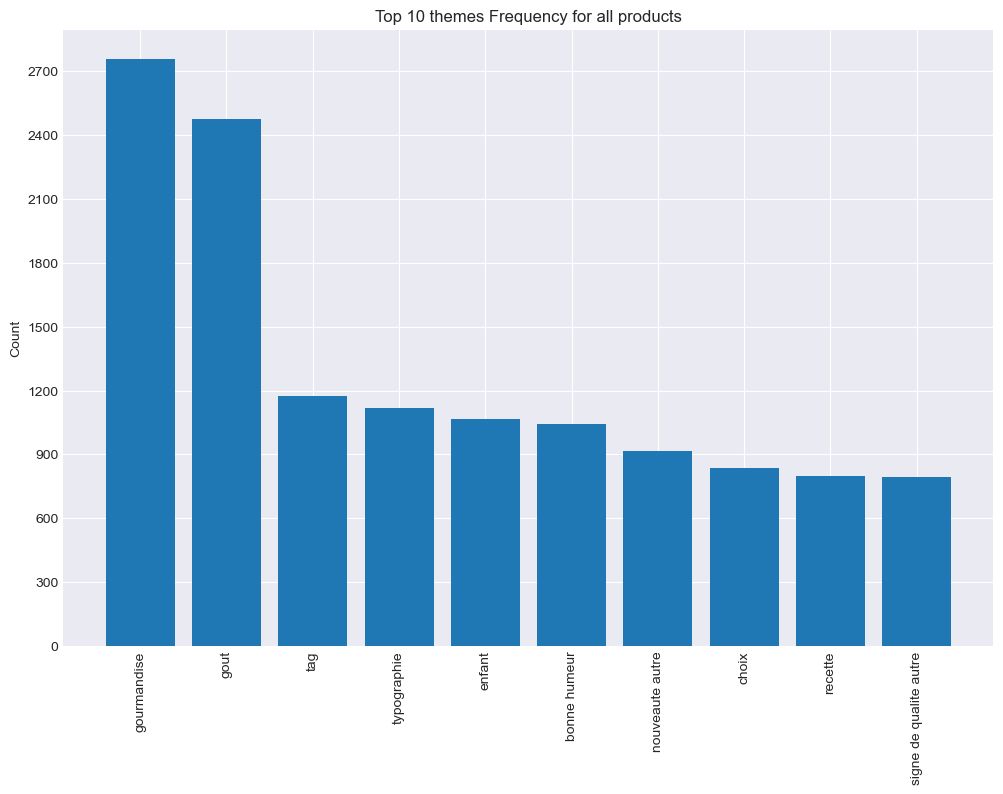

In [53]:
viz.visualize_top_10(freq_dist, "Top 10 themes Frequency for all products")

In [54]:
# TODO : analyse factorielle des correspondances

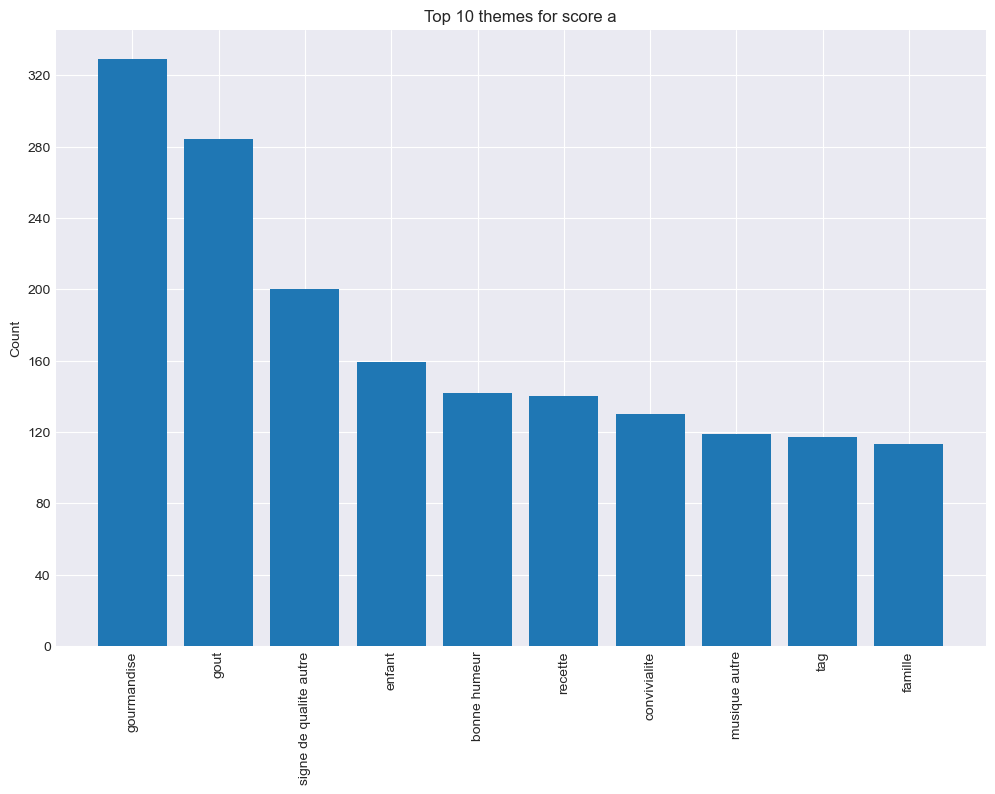

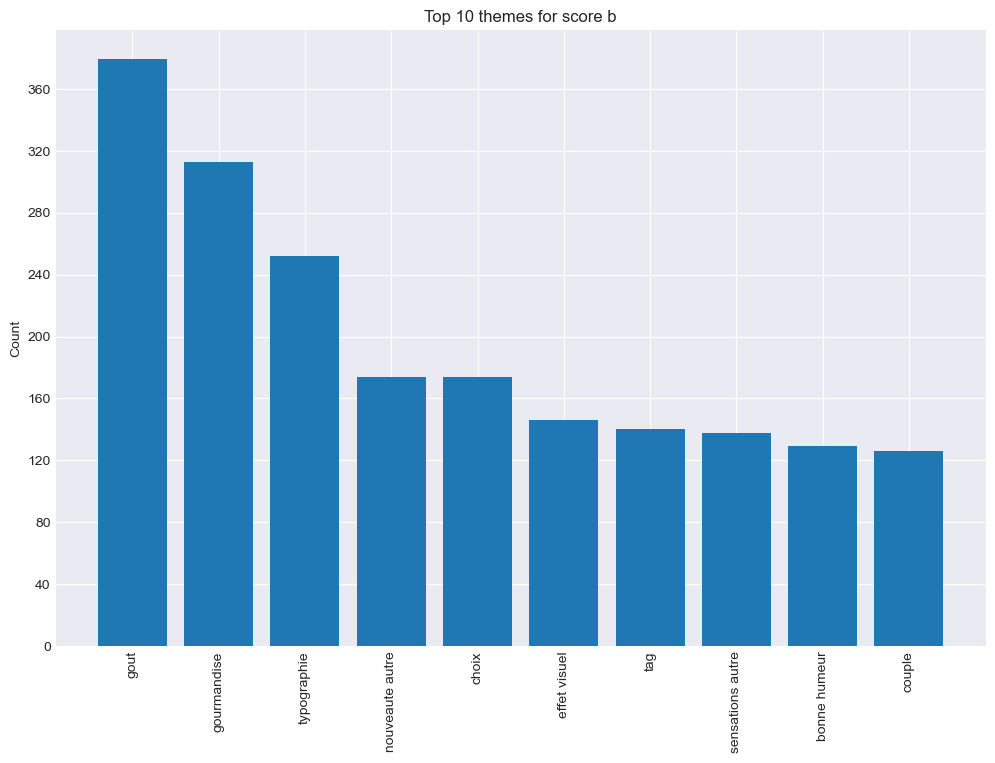

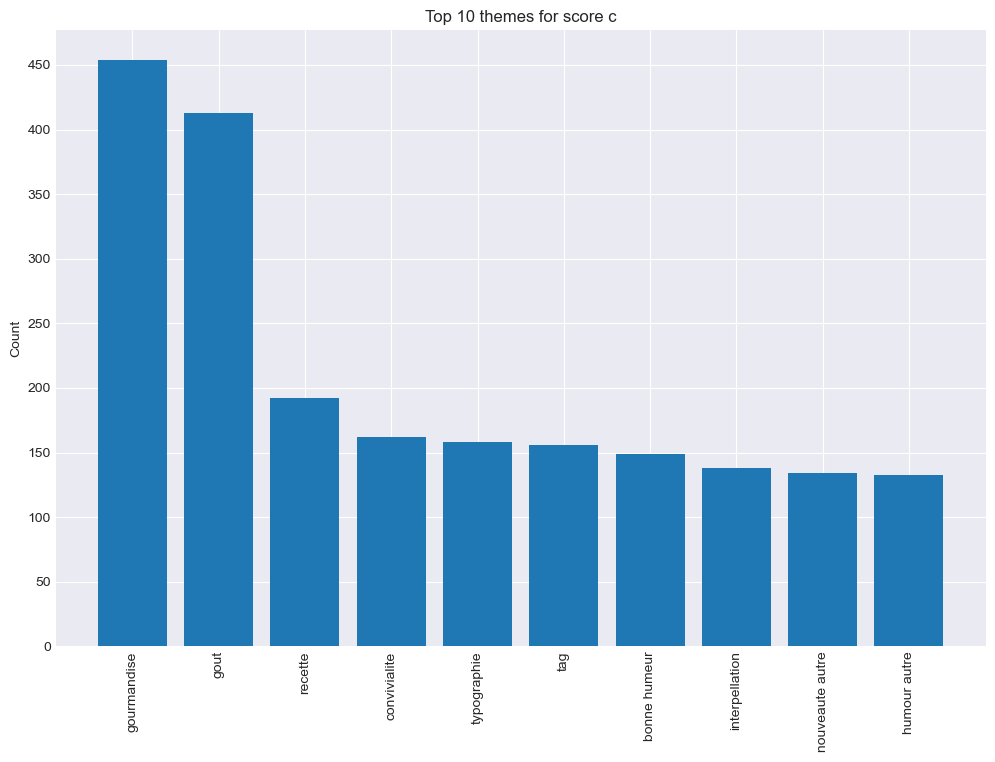

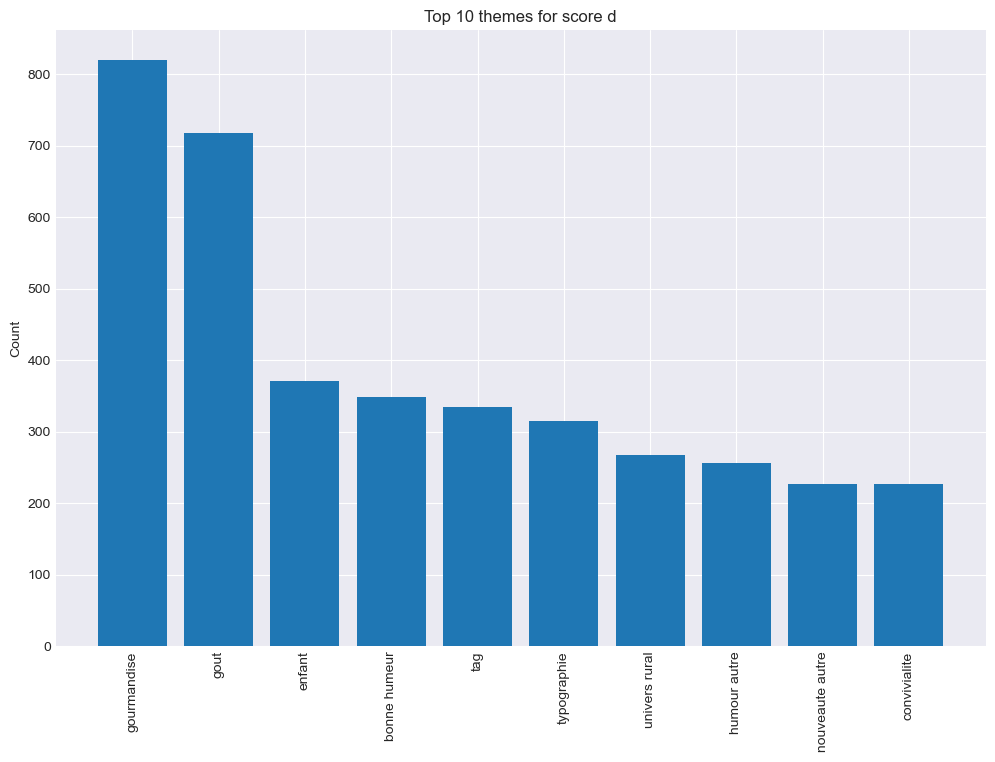

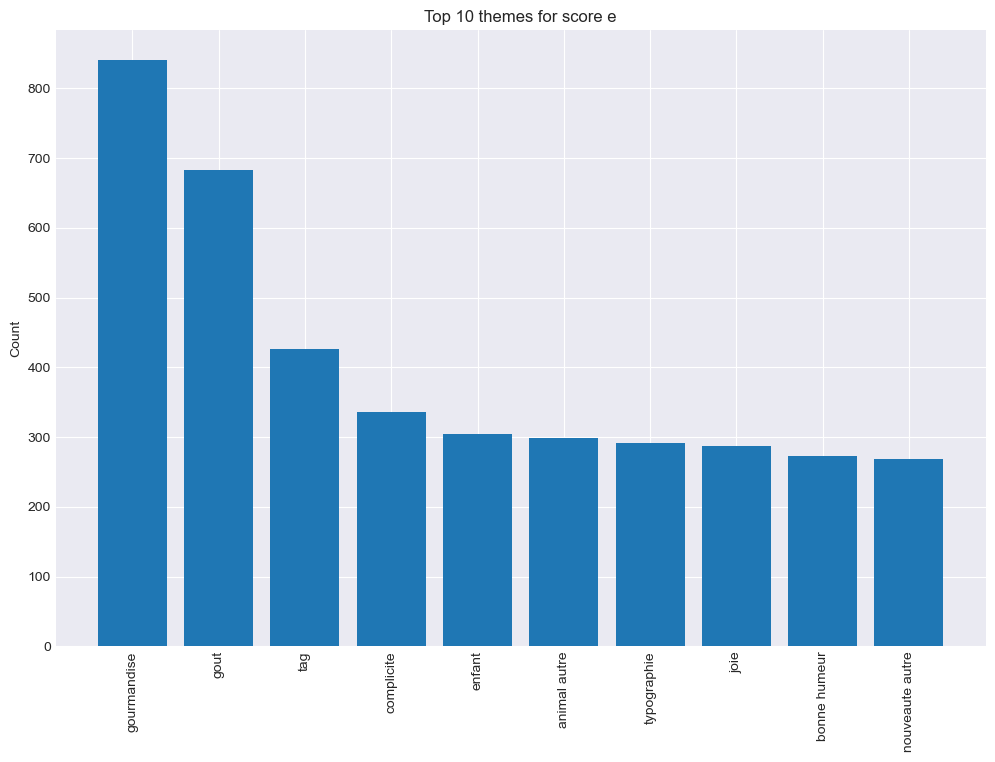

In [55]:
for score in score_list:
    sub_df = arcom_df[arcom_df['nutriscore_inferred'] == score]
    sub_freq_dist = FreqDist(sub_df['clean_theme'].explode())
    viz.visualize_top_10(sub_freq_dist, f"Top 10 themes for score {score}")

### Wordcloud

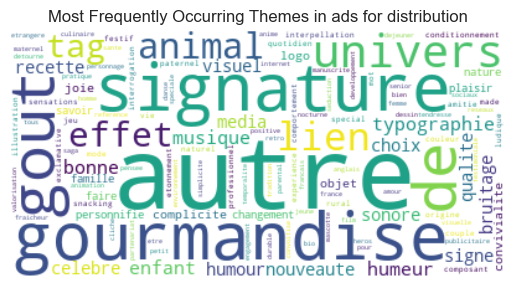

In [56]:
single_sentence_themes = [" ".join(theme) for theme in arcom_df['clean_theme']]
single_sentence_themes = " ".join(single_sentence_themes)


themes_cloud = WordCloud(collocations = False, background_color = 'white').generate(single_sentence_themes)
plt.imshow(themes_cloud, interpolation='bilinear')
plt.title('Most Frequently Occurring Themes in ads for distribution')
plt.axis("off")
plt.show()

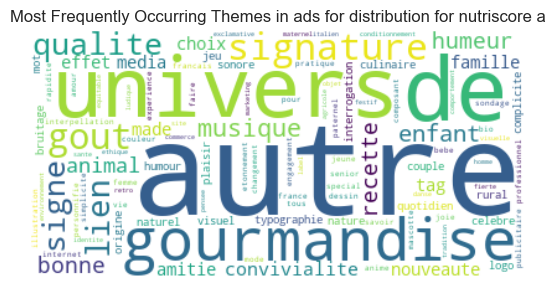

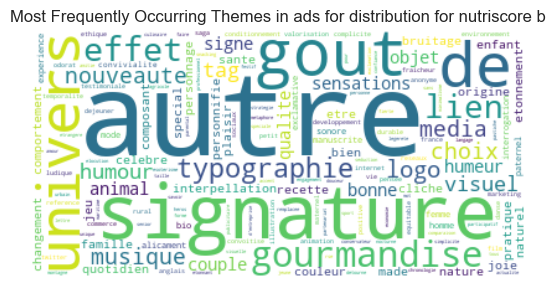

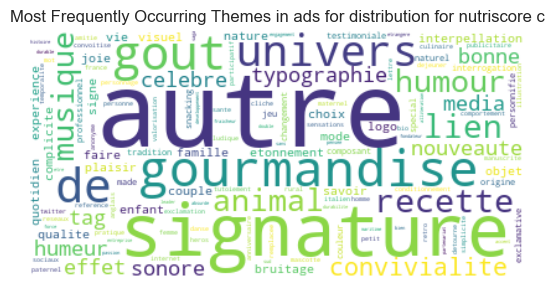

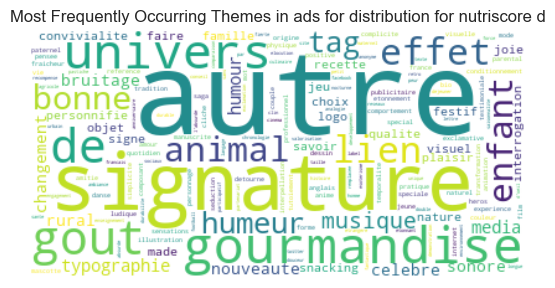

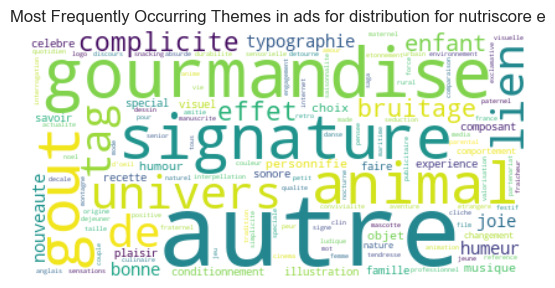

In [57]:
for score in score_list:
    sub_df = arcom_df[arcom_df['nutriscore_inferred'] == score]
    single_sentence_themes = [" ".join(single_sentence_themes) for single_sentence_themes in sub_df['clean_theme']]
    single_sentence_themes = " ".join(single_sentence_themes)


    themes_cloud = WordCloud(collocations = False, background_color = 'white').generate(single_sentence_themes)
    plt.imshow(themes_cloud, interpolation='bilinear')
    plt.title(f'Most Frequently Occurring Themes in ads for distribution for nutriscore {score}')
    plt.axis("off")
    plt.show()

## tf-idf

In [94]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

from sklearn.feature_selection import chi2

In [96]:

dictionary = Dictionary(arcom_df['clean_theme'])
dictionary
corpus = [dictionary.doc2bow(text) for text in arcom_df['clean_theme']]
model = TfidfModel(corpus)

tfidf_themes = [model[sentence] for sentence in corpus]
labels = list(arcom_df['nutriscore_inferred'])


AttributeError: 'list' object has no attribute 'lower'

In [93]:
chi2_scores, p_values = chi2(tfidf_themes, labels)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5564,) + inhomogeneous part.

## Mutual information

In [58]:

# This is a specific pmi for bag of words, where i only look for coocurrences
def compute_pmi(word_lists):
    # Flatten the list of lists to get a single list of words
    all_words = [word for sublist in word_lists for word in sublist]

    # Total number of words
    total_word_count = len(all_words)

    # Compute frequency of each word
    word_freq = Counter(all_words)

    # Compute frequency of each word pair
    pair_freq = defaultdict(int)
    for sublist in word_lists:
        for word1, word2 in combinations(sublist, 2):
            word_tuple = tuple(sorted((word1, word2)))
            pair_freq[word_tuple] += 1

    # Compute PMI for each word pair
    pmi = {}
    for (word1, word2), pair_count in pair_freq.items():
        p_word1 = word_freq[word1] / total_word_count
        p_word2 = word_freq[word2] / total_word_count
        p_word1_word2 = pair_count / total_word_count
        pmi[(word1, word2)] = math.log2(p_word1_word2 / (p_word1 * p_word2))

    return pmi

def get_top_n_pmi(pmi_dict, n=10):
    # Sort the dictionary by PMI values in descending order and take the top n items
    sorted_pmi = sorted(pmi_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_pmi[:n]


In [59]:
all_scores_pmi = compute_pmi(arcom_df['clean_theme'])
top_10_pmi = get_top_n_pmi(all_scores_pmi)

Text(0.5, 1.0, 'Mutual information for all ads')

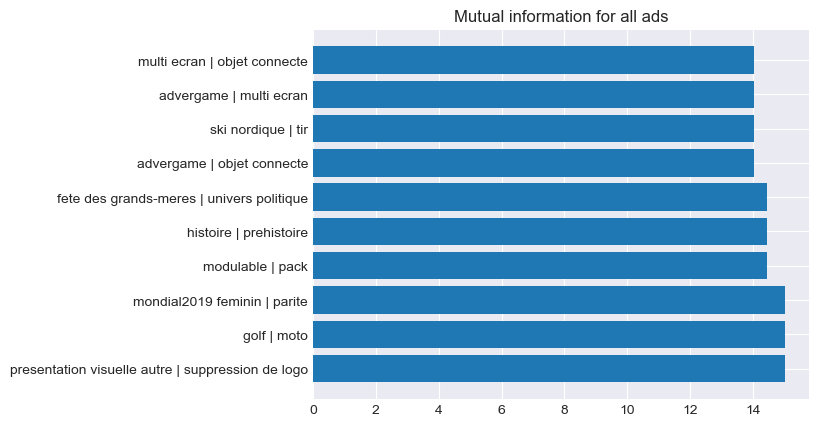

In [60]:
plt.barh([k[0] + " | " + k[1] for k, v in top_10_pmi], [v for k,v in top_10_pmi])
plt.title("Mutual information for all ads")

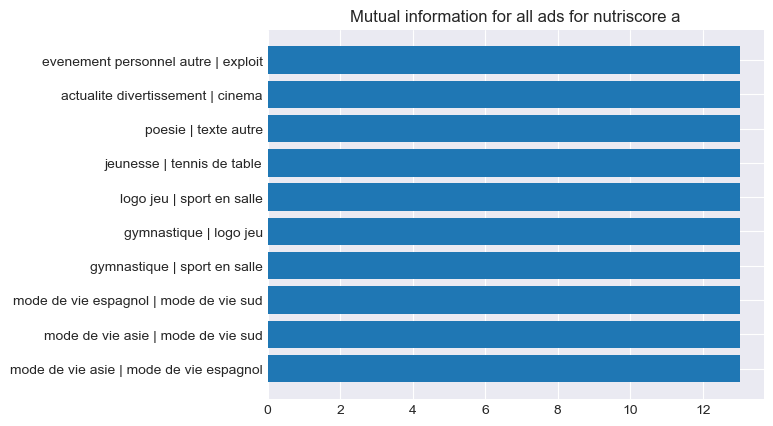

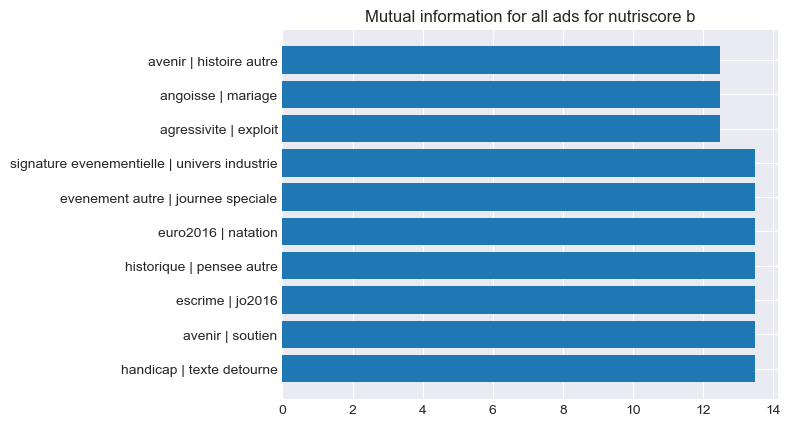

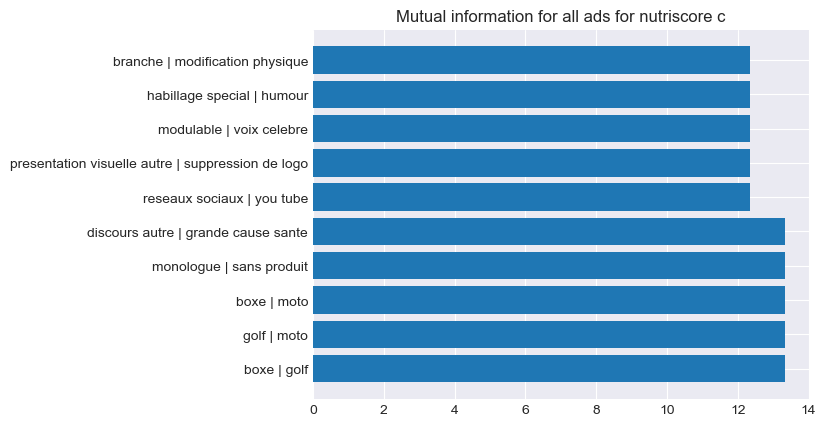

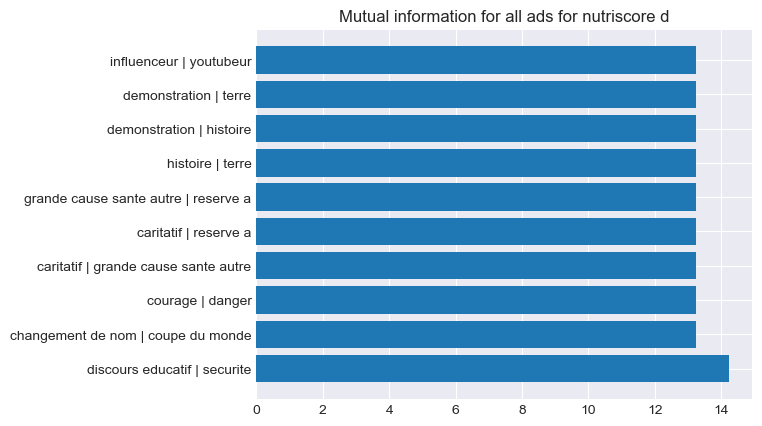

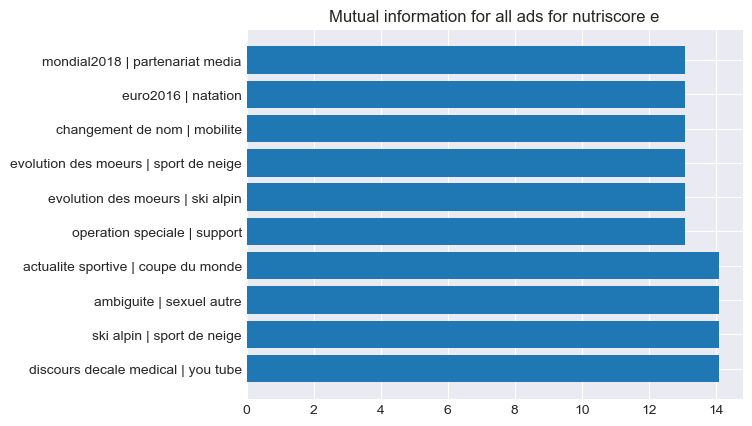

In [61]:
for score in score_list:
    sub_df = arcom_df[arcom_df['nutriscore_inferred'] == score]
    sub_scores_pmi = compute_pmi(sub_df['clean_theme'])
    sub_top_10_pmi = get_top_n_pmi(sub_scores_pmi)
    plt.barh([k[0] + " | " + k[1] for k, v in sub_top_10_pmi], [v for k,v in sub_top_10_pmi])
    plt.title(f"Mutual information for all ads for nutriscore {score}")
    plt.show()

## baseline model

In [62]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import class_weight
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


In [63]:
def get_scores(model, X_test, y_test):
    acc = accuracy_score(y_test, model.predict(X_test))
    prec = precision_score(y_test, model.predict(X_test), average='weighted')
    f1 = f1_score(y_test, model.predict(X_test), average='weighted')
    rec = recall_score(y_test, model.predict(X_test), average='weighted')
    output = {'Accuracy': acc, "Precision": prec, "Recall": rec, "F1 Score": f1}
    return output

In [64]:
label = LabelEncoder()

X = [' '.join(l) for l in arcom_df['clean_theme']]
y = label.fit_transform(list(arcom_df['nutriscore_inferred']))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
tfidf = TfidfVectorizer(max_features=1000)
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

### Naive bayes

In [66]:
bayes_model = MultinomialNB()
bayes_cv = cross_val_score(bayes_model, X_train_vectorized, y_train)
bayes_cv

array([0.54096521, 0.54606742, 0.53595506, 0.56741573, 0.55280899])

In [67]:
bayes_model.fit(X_train_vectorized, y_train)

MultinomialNB()

In [68]:
get_scores(bayes_model, X_train_vectorized, y_train)

{'Accuracy': 0.5994158616041338,
 'Precision': 0.62818968279529,
 'Recall': 0.5994158616041338,
 'F1 Score': 0.5829761875368932}

In [69]:
get_scores(bayes_model, X_test_vectorized, y_test)

{'Accuracy': 0.5651392632524708,
 'Precision': 0.5794856823555603,
 'Recall': 0.5651392632524708,
 'F1 Score': 0.5432377132738797}

#### Confusion matrix

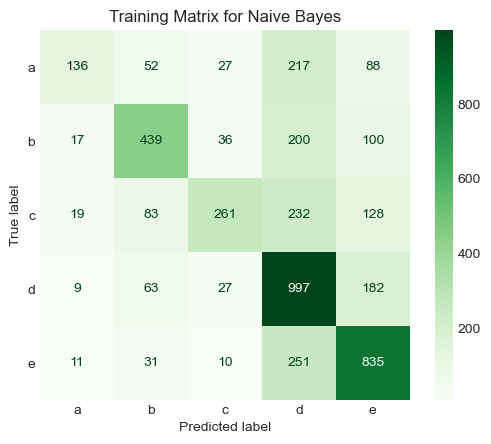

In [70]:
ConfusionMatrixDisplay.from_estimator(bayes_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Training Matrix for Naive Bayes')
plt.show()

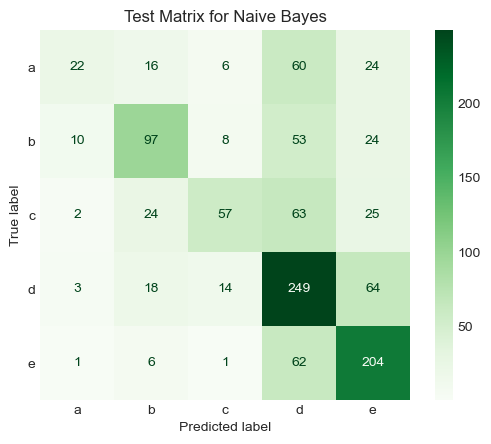

In [71]:
ConfusionMatrixDisplay.from_estimator(bayes_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Test Matrix for Naive Bayes')
plt.show()

### Random forest

In [72]:
forest_model = RandomForestClassifier()
forest_cv = cross_val_score(forest_model, X_train_vectorized, y_train)
forest_cv

array([0.83164983, 0.8247191 , 0.82359551, 0.82247191, 0.83820225])

In [73]:
forest_model.fit(X_train_vectorized, y_train)

RandomForestClassifier()

In [74]:
get_scores(forest_model, X_train_vectorized, y_train)

{'Accuracy': 0.9925859357447765,
 'Precision': 0.9926149313739135,
 'Recall': 0.9925859357447765,
 'F1 Score': 0.9925907809732426}

In [75]:
get_scores(forest_model, X_test_vectorized, y_test)

{'Accuracy': 0.8436657681940701,
 'Precision': 0.8473544134027176,
 'Recall': 0.8436657681940701,
 'F1 Score': 0.8431406341860739}

#### Confusion matrix

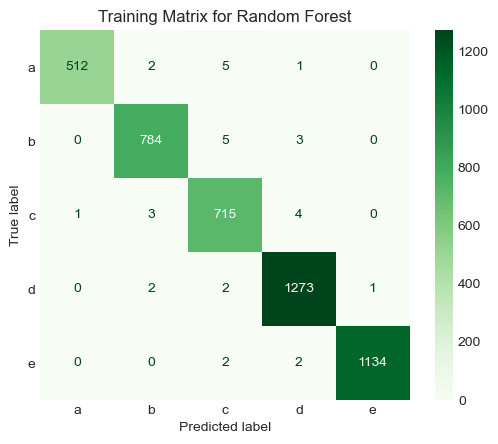

In [76]:
ConfusionMatrixDisplay.from_estimator(forest_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Training Matrix for Random Forest')
plt.show()

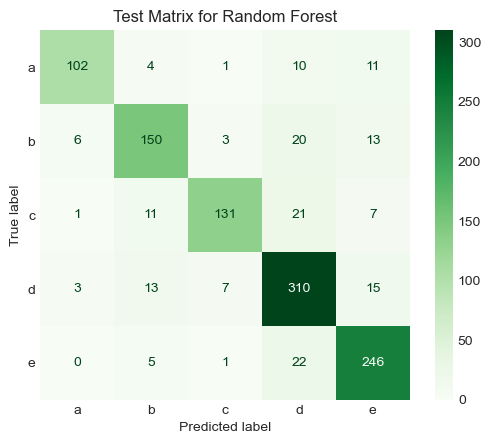

In [77]:
ConfusionMatrixDisplay.from_estimator(forest_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Test Matrix for Random Forest')
plt.show()

## Interpreting models

In [36]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [37]:
explainer = LimeTextExplainer(class_names=label.classes_)

### Naive bayes interpretation

In [38]:
nb = make_pipeline(tfidf, bayes_model)

In [39]:
predictions = nb.predict(X)
predictions = [label.classes_[p] for p in predictions]

true_class = [label.classes_[val] for val in y]
data = X

In [40]:
idx = 660
exp_nb = explainer.explain_instance(data[idx], nb.predict_proba, labels=[0, 1, 2, 3, 4])
print('Index: %d' % idx)
print('Predicted class =', predictions[idx])
print('True class: %s' % true_class[idx])

exp_nb.save_to_file(text=True, file_path=f'lime_naive_bayes_{idx}.html')

Index: 660
Predicted class = a
True class: a


### Random forest explanation

In [53]:
arcom_df.loc[1, ['Marque', 'Produit', 'Script', 'clean_theme']]

Marque                                        FRUIT D OR OMEGA 3
Produit                                     FRUIT D OR OMEGA 3&6
Script         Voix homme : " Hugo, notre expert en graines.\...
clean_theme    [sante, naturel, composant special, dialogue, ...
Name: 1, dtype: object

In [41]:
rf = make_pipeline(tfidf, bayes_model)

predictions = rf.predict(X)
predictions = [label.classes_[p] for p in predictions]

true_class = [label.classes_[val] for val in y]
data = X

In [54]:
idx = 1
exp_rf = explainer.explain_instance(data[idx], rf.predict_proba, labels=[0, 1, 2, 3, 4])
print('Index: %d' % idx)
print('Predicted class =', predictions[idx])
print('True class: %s' % true_class[idx])

exp_rf.save_to_file(text=True, file_path=f'lime_random_forest_{idx}.html')

Index: 1
Predicted class = c
True class: d


## Prediction on specific products

In [49]:
def prediction_on_given_product(variete):
    sub_df = arcom_df[arcom_df['Variété'] == variete]

    sub_X = [' '.join(l) for l in sub_df['clean_theme']]
    sub_X_vectorized = tfidf.transform(sub_X)
    sub_y = label.transform(list(sub_df['nutriscore_inferred']))

    for k, v in get_scores(forest_model, X_test_vectorized, y_test).items():
        print(f'{k} : {v}')

    ConfusionMatrixDisplay.from_estimator(forest_model, sub_X_vectorized, sub_y, display_labels=label.classes_, cmap="Greens")
    plt.grid(False)
    plt.title(f'Confusion matrix for random forest on {variete} products')
    plt.show()

Accuracy : 0.8508535489667565
Precision : 0.8549507014451078
Recall : 0.8508535489667565
F1 Score : 0.8504180052078146


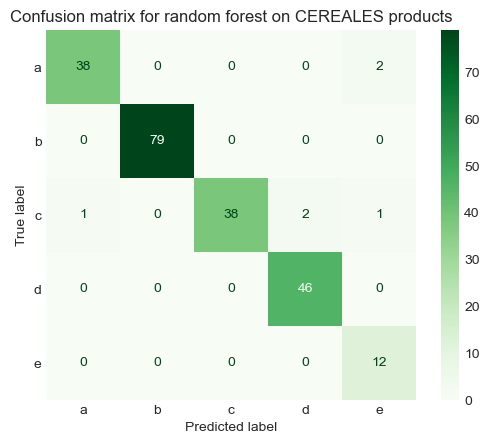

In [50]:
prediction_on_given_product('CEREALES')